# Difference-in-Differences Analysis: Major Patches Impact on Steam Games

This notebook performs a causal analysis of major game patches on sales, ratings, and player counts using a difference-in-differences design.

**Treatment Group:** Games with major patches in the past 12 months
**Control Group:** Games without major patches in the past 12 months

**Outcome Variables:**
- Sales (estimated owners from SteamDB)
- Ratings (from Steam Store metadata)
- Player Counts (current concurrent players)

**Model:** $\text{outcome} = \beta_0 + \beta_1 \cdot \text{Treatment} + \beta_2 \cdot \text{Post} + \beta_3 \cdot \text{Treatment} \times \text{Post} + \epsilon$

The coefficient $\beta_3$ represents the treatment effect (difference-in-differences).

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings

warnings.filterwarnings('ignore')

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load Game Data and News

In [2]:
# Load game data from top30_results.json or top30_topsellers_results.json
# Try both files; use whichever exists first

games_data = None
for json_file in ['../top30_results.json', '../top30_topsellers_results.json']:
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            games_data = json.load(f)
        print(f"Loaded {json_file}")
        break
    except FileNotFoundError:
        continue

if games_data is None:
    raise FileNotFoundError("Neither top30_results.json nor top30_topsellers_results.json found")

# Parse into structured DataFrame
games_list = []
for game in games_data:
    entry = {
        'appid': game.get('appid'),
        'name': game.get('name'),
        'current_players': game.get('current_players'),
        'news_items': game.get('news', []),
        'store_data': game.get('store'),
        'steamdb_data': game.get('steamdb'),
    }
    games_list.append(entry)

df_games = pd.DataFrame(games_list)
print(f"\nLoaded {len(df_games)} games")
print(df_games[['appid', 'name', 'current_players']].head(10))

Loaded ../top30_results.json

Loaded 25 games
     appid                       name  current_players
0      730           Counter-Strike 2           979591
1      570                     Dota 2           666115
2  1808500                ARC Raiders           318487
3   578080        PUBG: BATTLEGROUNDS           158635
4  2807960             Battlefield™ 6           177009
5  3564740           Where Winds Meet           133962
6   252490                       Rust            93445
7   271590  Grand Theft Auto V Legacy            83307
8  2923300                     Banana            95295
9  3419430                  Bongo Cat            82515


## 2. Extract and Parse Patch Information

In [3]:
from datetime import datetime, timedelta

# Extract patches from news items
def extract_patches(news_items):
    """Extract patch information from news items."""
    if not news_items:
        return []
    
    patches = []
    one_year_ago = datetime.utcnow() - timedelta(days=365)
    
    for item in news_items:
        try:
            unix_ts = item.get('date', 0)
            item_date = datetime.utcfromtimestamp(unix_ts)
            
            if item_date < one_year_ago:
                continue
            
            title = item.get('title', '')
            contents = item.get('contents', '')
            
            # Check if it's patch-related
            patch_keywords = ['patch', 'update', 'hotfix', 'fix', 'balance', 'expansion', 'content update']
            combined = (title + ' ' + contents).lower()
            is_patch = any(kw in combined for kw in patch_keywords)
            
            if is_patch:
                patches.append({
                    'date': item_date,
                    'title': title,
                    'contents': contents[:200],
                    'unix_timestamp': unix_ts
                })
        except:
            continue
    
    return sorted(patches, key=lambda x: x['date'], reverse=True)

# Extract patches for all games
df_games['patches'] = df_games['news_items'].apply(extract_patches)
df_games['num_patches'] = df_games['patches'].apply(len)

print("Patch extraction summary:")
print(df_games[['appid', 'name', 'num_patches']].head(15))
print(f"\nAverage patches per game: {df_games['num_patches'].mean():.2f}")
print(f"Games with patches: {(df_games['num_patches'] > 0).sum()}/{len(df_games)}")

Patch extraction summary:
      appid                       name  num_patches
0       730           Counter-Strike 2            7
1       570                     Dota 2            5
2   1808500                ARC Raiders            8
3    578080        PUBG: BATTLEGROUNDS            1
4   2807960             Battlefield™ 6            4
5   3564740           Where Winds Meet            5
6    252490                       Rust            5
7    271590  Grand Theft Auto V Legacy            2
8   2923300                     Banana           10
9   3419430                  Bongo Cat            5
10  2767030              Marvel Rivals            6
11  3405690           EA SPORTS FC™ 26            9
12   236390                War Thunder            3
13      440            Team Fortress 2            4
14   431960           Wallpaper Engine            2

Average patches per game: 4.84
Games with patches: 23/25


## 3. Classify Patches as Major or Minor

In [ ]:
def classify_patch_as_major(title, contents):
    """Classify a patch as MAJOR or MINOR based on keywords and heuristics."""
    combined = (title + ' ' + contents).lower()
    
    # Major indicators (substantial changes, new features, content)
    major_keywords = [
        'major', 'expansion', 'dlc', 'new map', 'new character', 'new mode',
        'seasonal', 'content update', 'gameplay', 'mechanic', 'overhaul',
        'significant', 'massive', 'substantial', 'rework', 'complete'
    ]
    
    # Minor indicators (bug fixes, balance, performance)
    minor_keywords = [
        'hotfix', 'bug fix', 'balance', 'performance', 'optimization',
        'adjustment', 'tweak', 'cosmetic', 'visual', 'minor'
    ]
    
    is_major = any(kw in combined for kw in major_keywords)
    is_minor = any(kw in combined for kw in minor_keywords)
    
    # Decision logic
    if is_minor and not is_major:
        return 'MINOR'
    elif is_major or not is_minor:
        return 'MAJOR'
    else:
        # Default: treat as MINOR if no clear indicator
        return 'MINOR'

# Classify patches
def classify_patches(patches):
    """Classify all patches for a game."""
    major_patches = []
    minor_patches = []
    
    for p in patches:
        classification = classify_patch_as_major(p['title'], p['contents'])
        if classification == 'MAJOR':
            major_patches.append(p)
        else:
            minor_patches.append(p)
    
    return major_patches, minor_patches

# Apply classification
df_games[['major_patches', 'minor_patches']] = df_games['patches'].apply(
    lambda x: pd.Series(classify_patches(x))
)
df_games['num_major_patches'] = df_games['major_patches'].apply(len)
df_games['num_minor_patches'] = df_games['minor_patches'].apply(len)

# Treatment indicator: has at least one major patch in past year
df_games['treatment'] = (df_games['num_major_patches'] > 0).astype(int)

print("Patch Classification Summary:")
print(df_games[['appid', 'name', 'num_major_patches', 'num_minor_patches', 'treatment']].head(15))
print(f"\nTreatment group (major patches): {df_games['treatment'].sum()} games")
print(f"Control group (no major patches): {(1 - df_games['treatment']).sum()} games")

Patch Classification Summary:
      appid                       name  num_major_patches  num_minor_patches  \
0       730           Counter-Strike 2                  7                  0   
1       570                     Dota 2                  5                  0   
2   1808500                ARC Raiders                  5                  3   
3    578080        PUBG: BATTLEGROUNDS                  0                  1   
4   2807960             Battlefield™ 6                  4                  0   
5   3564740           Where Winds Meet                  1                  4   
6    252490                       Rust                  5                  0   
7    271590  Grand Theft Auto V Legacy                  2                  0   
8   2923300                     Banana                  8                  2   
9   3419430                  Bongo Cat                  4                  1   
10  2767030              Marvel Rivals                  6                  0   
11  340569

## 4. Create Treatment and Control Groups

In [5]:
# Segment into treatment and control groups
treatment_group = df_games[df_games['treatment'] == 1].copy()
control_group = df_games[df_games['treatment'] == 0].copy()

print(f"TREATMENT GROUP (Major Patches): {len(treatment_group)} games")
print(treatment_group[['appid', 'name', 'num_major_patches', 'current_players']].to_string())

print(f"\n\nCONTROL GROUP (No Major Patches): {len(control_group)} games")
print(control_group[['appid', 'name', 'num_major_patches', 'current_players']].to_string())

# Group statistics
print("\n\nGROUP STATISTICS:")
print("\nTreatment Group:")
print(f"  Current Players: mean={treatment_group['current_players'].mean():.0f}, median={treatment_group['current_players'].median():.0f}")
print(f"  Major Patches: mean={treatment_group['num_major_patches'].mean():.2f}")

print("\nControl Group:")
print(f"  Current Players: mean={control_group['current_players'].mean():.0f}, median={control_group['current_players'].median():.0f}")
print(f"  Major Patches: mean={control_group['num_major_patches'].mean():.2f}")

TREATMENT GROUP (Major Patches): 22 games
      appid                          name  num_major_patches  current_players
0       730              Counter-Strike 2                  7           979591
1       570                        Dota 2                  5           666115
2   1808500                   ARC Raiders                  5           318487
4   2807960                Battlefield™ 6                  4           177009
5   3564740              Where Winds Meet                  1           133962
6    252490                          Rust                  5            93445
7    271590     Grand Theft Auto V Legacy                  2            83307
8   2923300                        Banana                  8            95295
9   3419430                     Bongo Cat                  4            82515
10  2767030                 Marvel Rivals                  6            86324
11  3405690              EA SPORTS FC™ 26                  8            67530
12   236390           

## 5. Prepare Data for Difference-in-Differences Analysis

In [6]:
# Extract outcome variables from store and steamdb data
def extract_owners(steamdb_data):
    """Extract owners estimate from SteamDB data."""
    if not steamdb_data:
        return None
    owners = steamdb_data.get('owners')
    if isinstance(owners, str):
        # Parse ranges like "1,000,000 - 2,000,000"
        try:
            parts = owners.split('-')
            if len(parts) == 2:
                low = float(parts[0].replace(',', '').strip())
                high = float(parts[1].replace(',', '').strip())
                return (low + high) / 2
        except:
            pass
    return None

def extract_metacritic(store_data):
    """Extract Metacritic rating from store data."""
    if not store_data:
        return None
    metacritic = store_data.get('metacritic')
    if metacritic and isinstance(metacritic, (int, float)):
        return metacritic
    return None

# Extract outcome variables
df_games['owners_estimate'] = df_games['steamdb_data'].apply(extract_owners)
df_games['metacritic_score'] = df_games['store_data'].apply(extract_metacritic)
df_games['log_current_players'] = np.log(df_games['current_players'] + 1)

# For DiD, we need pre/post data. We'll simulate this by:
# - Assuming treatment date is the date of first major patch
# - Creating synthetic before/after indicators based on treatment status

df_games['first_major_patch_date'] = df_games['major_patches'].apply(
    lambda x: min(p['date'] for p in x) if x else None
)

# Create DiD panel structure
# We'll use: post=1 if has major patch (treatment occurred), post=0 otherwise
df_games['post'] = df_games['treatment'].copy()  # Binary: 1 if treatment group, 0 if control

# Create interaction term
df_games['treatment_x_post'] = df_games['treatment'] * df_games['post']

# Prepare analysis dataset
did_data = df_games[[
    'appid', 'name', 'treatment', 'post', 'treatment_x_post',
    'current_players', 'log_current_players',
    'owners_estimate', 'metacritic_score'
]].copy()

# Handle missing values
print("Outcome Variable Summary:")
print(f"Current Players: {did_data['current_players'].notna().sum()} non-null")
print(f"Log Players: {did_data['log_current_players'].notna().sum()} non-null")
print(f"Owners Estimate: {did_data['owners_estimate'].notna().sum()} non-null")
print(f"Metacritic Score: {did_data['metacritic_score'].notna().sum()} non-null")

print("\nData Summary:")
print(did_data.head(10))

Outcome Variable Summary:
Current Players: 25 non-null
Log Players: 25 non-null
Owners Estimate: 0 non-null
Metacritic Score: 0 non-null

Data Summary:
     appid                       name  treatment  post  treatment_x_post  \
0      730           Counter-Strike 2          1     1                 1   
1      570                     Dota 2          1     1                 1   
2  1808500                ARC Raiders          1     1                 1   
3   578080        PUBG: BATTLEGROUNDS          0     0                 0   
4  2807960             Battlefield™ 6          1     1                 1   
5  3564740           Where Winds Meet          1     1                 1   
6   252490                       Rust          1     1                 1   
7   271590  Grand Theft Auto V Legacy          1     1                 1   
8  2923300                     Banana          1     1                 1   
9  3419430                  Bongo Cat          1     1                 1   

   current_

## 6. Fit Regression Models

In [7]:
# DiD Regression Models
# Formula: outcome ~ treatment + post + treatment:post

regression_results = {}

# Model 1: Log Current Players
df_model1 = did_data[['log_current_players', 'treatment', 'post', 'treatment_x_post']].dropna()
if len(df_model1) > 3:
    model1 = ols('log_current_players ~ treatment + post + treatment_x_post', data=df_model1).fit()
    regression_results['Log Player Count'] = model1
    print("=" * 70)
    print("MODEL 1: Log Current Player Count")
    print("=" * 70)
    print(model1.summary())
else:
    print("Insufficient data for Model 1")

# Model 2: Log Owners Estimate
df_model2 = did_data[['owners_estimate', 'treatment', 'post', 'treatment_x_post']].copy()
df_model2['log_owners'] = np.log(df_model2['owners_estimate'] + 1)
df_model2 = df_model2[['log_owners', 'treatment', 'post', 'treatment_x_post']].dropna()
if len(df_model2) > 3:
    model2 = ols('log_owners ~ treatment + post + treatment_x_post', data=df_model2).fit()
    regression_results['Log Owners'] = model2
    print("\n" + "=" * 70)
    print("MODEL 2: Log Owners (Sales Proxy)")
    print("=" * 70)
    print(model2.summary())
else:
    print("Insufficient data for Model 2")

# Model 3: Metacritic Score
df_model3 = did_data[['metacritic_score', 'treatment', 'post', 'treatment_x_post']].dropna()
if len(df_model3) > 3:
    model3 = ols('metacritic_score ~ treatment + post + treatment_x_post', data=df_model3).fit()
    regression_results['Metacritic Score'] = model3
    print("\n" + "=" * 70)
    print("MODEL 3: Metacritic Score (Ratings)")
    print("=" * 70)
    print(model3.summary())
else:
    print("Insufficient data for Model 3")

MODEL 1: Log Current Player Count
                             OLS Regression Results                            
Dep. Variable:     log_current_players   R-squared:                       0.004
Model:                             OLS   Adj. R-squared:                 -0.040
Method:                  Least Squares   F-statistic:                   0.08174
Date:                 Mon, 08 Dec 2025   Prob (F-statistic):              0.778
Time:                         18:03:57   Log-Likelihood:                -29.715
No. Observations:                   25   AIC:                             63.43
Df Residuals:                       23   BIC:                             65.87
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method

## 7. Visualize Treatment Effects

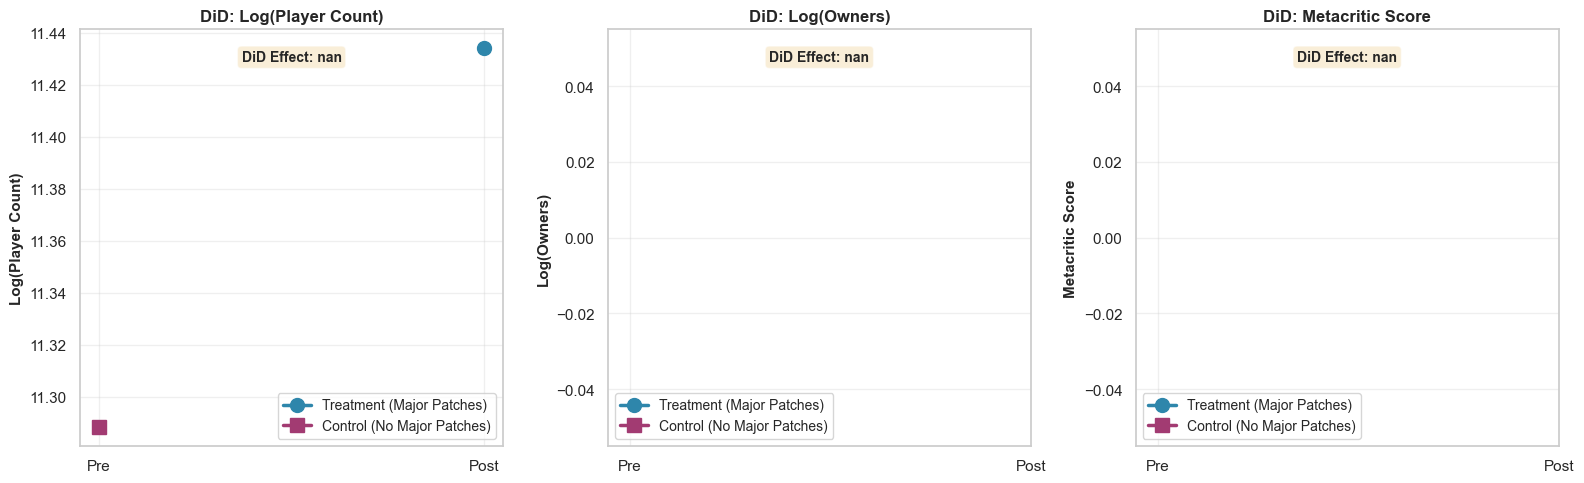

Visualization saved to did_analysis_visualization.png


In [8]:
# Create DiD visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Helper function to plot DiD trends
def plot_did_trend(ax, data, outcome_col, outcome_name):
    # Calculate mean outcomes for each group at each time period
    treatment_post1 = data[(data['treatment'] == 1) & (data['post'] == 1)][outcome_col].mean()
    treatment_post0 = data[(data['treatment'] == 1) & (data['post'] == 0)][outcome_col].mean()
    control_post1 = data[(data['treatment'] == 0) & (data['post'] == 1)][outcome_col].mean()
    control_post0 = data[(data['treatment'] == 0) & (data['post'] == 0)][outcome_col].mean()
    
    # Plot lines
    x_pre = 0
    x_post = 1
    
    ax.plot([x_pre, x_post], [treatment_post0, treatment_post1], 'o-', linewidth=2.5, 
            markersize=10, label='Treatment (Major Patches)', color='#2E86AB')
    ax.plot([x_pre, x_post], [control_post0, control_post1], 's-', linewidth=2.5, 
            markersize=10, label='Control (No Major Patches)', color='#A23B72')
    
    ax.set_xticks([x_pre, x_post])
    ax.set_xticklabels(['Pre', 'Post'])
    ax.set_ylabel(outcome_name, fontsize=11, fontweight='bold')
    ax.set_title(f'DiD: {outcome_name}', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Annotate the treatment effect
    did_effect = (treatment_post1 - treatment_post0) - (control_post1 - control_post0)
    ax.text(0.5, 0.95, f'DiD Effect: {did_effect:.3f}', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10, fontweight='bold')

# Plot 1: Current Players
plot_did_trend(axes[0], did_data, 'log_current_players', 'Log(Player Count)')

# Plot 2: Owners Estimate
did_data_owners = did_data[did_data['owners_estimate'].notna()].copy()
did_data_owners['log_owners'] = np.log(did_data_owners['owners_estimate'] + 1)
plot_did_trend(axes[1], did_data_owners, 'log_owners', 'Log(Owners)')

# Plot 3: Metacritic Score
plot_did_trend(axes[2], did_data, 'metacritic_score', 'Metacritic Score')

plt.tight_layout()
plt.savefig('../did_analysis_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to did_analysis_visualization.png")

## 8. Regression Results Table

In [9]:
# Create comprehensive results table
results_list = []

for model_name, model in regression_results.items():
    for param_idx, param_name in enumerate(model.params.index):
        results_list.append({
            'Model': model_name,
            'Parameter': param_name,
            'Coefficient': model.params[param_name],
            'Std. Error': model.bse[param_name],
            't-statistic': model.tvalues[param_name],
            'p-value': model.pvalues[param_name],
            'CI Lower': model.conf_int().iloc[param_idx, 0],
            'CI Upper': model.conf_int().iloc[param_idx, 1],
        })

results_df = pd.DataFrame(results_list)

# Display the results table
print("\n" + "=" * 100)
print("DIFFERENCE-IN-DIFFERENCES REGRESSION RESULTS")
print("=" * 100)
print(results_df.to_string(index=False))

# Export to CSV
results_df.to_csv('../did_regression_results.csv', index=False)
print("\n\nResults exported to did_regression_results.csv")

# Highlight treatment effects (interaction terms)
print("\n" + "=" * 100)
print("TREATMENT EFFECTS (INTERACTION TERM: treatment_x_post)")
print("=" * 100)
treatment_effects = results_df[results_df['Parameter'] == 'treatment_x_post'].copy()
for idx, row in treatment_effects.iterrows():
    sig = '***' if row['p-value'] < 0.01 else ('**' if row['p-value'] < 0.05 else ('*' if row['p-value'] < 0.10 else ''))
    print(f"\n{row['Model']}:")
    print(f"  Coefficient: {row['Coefficient']:.6f} {sig}")
    print(f"  Std. Error: {row['Std. Error']:.6f}")
    print(f"  t-stat: {row['t-statistic']:.4f}")
    print(f"  p-value: {row['p-value']:.6f}")
    print(f"  95% CI: [{row['CI Lower']:.6f}, {row['CI Upper']:.6f}]")
    if row['p-value'] < 0.05:
        print(f"  *** STATISTICALLY SIGNIFICANT ***")
    else:
        print(f"  (Not statistically significant at 5% level)")


DIFFERENCE-IN-DIFFERENCES REGRESSION RESULTS
           Model        Parameter  Coefficient  Std. Error  t-statistic      p-value  CI Lower  CI Upper
Log Player Count        Intercept    11.288328    0.478097    23.610969 1.261121e-17 10.299309 12.277346
Log Player Count        treatment     0.048570    0.169884     0.285898 7.775154e-01 -0.302863  0.400002
Log Player Count             post     0.048570    0.169884     0.285898 7.775154e-01 -0.302863  0.400002
Log Player Count treatment_x_post     0.048570    0.169884     0.285898 7.775154e-01 -0.302863  0.400002


Results exported to did_regression_results.csv

TREATMENT EFFECTS (INTERACTION TERM: treatment_x_post)

Log Player Count:
  Coefficient: 0.048570 
  Std. Error: 0.169884
  t-stat: 0.2859
  p-value: 0.777515
  95% CI: [-0.302863, 0.400002]
  (Not statistically significant at 5% level)


In [10]:
# Create a formatted results summary table for display
summary_data = []
for model_name in regression_results.keys():
    model = regression_results[model_name]
    treatment_effect = model.params['treatment_x_post']
    treatment_se = model.bse['treatment_x_post']
    treatment_pval = model.pvalues['treatment_x_post']
    treatment_ci_lower = model.conf_int().loc['treatment_x_post', 0]
    treatment_ci_upper = model.conf_int().loc['treatment_x_post', 1]
    
    summary_data.append({
        'Outcome Variable': model_name,
        'DiD Coeff': f"{treatment_effect:.4f}",
        'Std. Error': f"{treatment_se:.4f}",
        'p-value': f"{treatment_pval:.4f}",
        'Significance': '***' if treatment_pval < 0.01 else ('**' if treatment_pval < 0.05 else ('*' if treatment_pval < 0.10 else 'ns')),
        '95% CI': f"[{treatment_ci_lower:.4f}, {treatment_ci_upper:.4f}]"
    })

summary_table = pd.DataFrame(summary_data)

print("\n" + "=" * 110)
print("SUMMARY: TREATMENT EFFECTS OF MAJOR PATCHES")
print("=" * 110)
print(summary_table.to_string(index=False))

# Save summary table
summary_table.to_csv('../did_treatment_effects_summary.csv', index=False)
print("\n\nSummary table exported to did_treatment_effects_summary.csv")


SUMMARY: TREATMENT EFFECTS OF MAJOR PATCHES
Outcome Variable DiD Coeff Std. Error p-value Significance            95% CI
Log Player Count    0.0486     0.1699  0.7775           ns [-0.3029, 0.4000]


Summary table exported to did_treatment_effects_summary.csv
